<a href="https://colab.research.google.com/github/alexre24/Food-Sales-Predictions/blob/main/Project_1_Part_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree
from sklearn import set_config
set_config(display='diagram') 

In [25]:
path = '/content/drive/MyDrive/Coding Dojo/02 Week 2: Manipulating and Understanding Data/sales_predictions.csv'
df = pd.read_csv(path)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [26]:
sales_df = df.copy()

## Cleaning Data

In [27]:
sales_df.isna().sum().sum()

3873

In [28]:
sales_df.duplicated().sum()

0

In [29]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [30]:
sales_df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [31]:
sales_df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [32]:
sales_df.replace(["LF"], ["Low Fat"], inplace=True)
sales_df.replace(["low fat"], ["Low Fat"], inplace=True)
sales_df.replace(["reg"], ["Regular"], inplace=True)
sales_df["Item_Fat_Content"].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [33]:
y = sales_df['Item_Outlet_Sales']
X = sales_df[['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Size', 'Outlet_Type']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [34]:
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown = 'ignore')

#Preprocessing

In [35]:
mean_imputer = SimpleImputer(strategy = 'mean')
freq_imputer = SimpleImputer(strategy = 'most_frequent')

In [36]:
num_pipeline = make_pipeline(mean_imputer, scaler)
nom_pipeline = make_pipeline(freq_imputer, ohe)

In [37]:
nominal_cols = ['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Type', 'Outlet_Size']
num_selector = ['Item_Weight', 'Item_Visibility', 'Item_MRP']

In [38]:
numeric_tuple = (num_pipeline, num_selector)
nominal_tuple = (nom_pipeline, nominal_cols)

In [39]:
preprocessor = make_column_transformer(numeric_tuple,
                                       nominal_tuple, remainder = 'drop')

#Model Metrics Function

In [40]:
#Creating a function to take true and predicted values
def model_metrics(pipe, x_train, y_train, x_test, y_test, 
                       model_name='Regression Model', ):
  ## Train
  mae = round(mean_absolute_error(y_train, pipe.predict(x_train)),4)
  mse = round(mean_squared_error(y_train, pipe.predict(x_train)),4)
  rmse = round(np.sqrt(mean_squared_error(y_train, pipe.predict(x_train))),4)
  r2 = round(r2_score(y_train, pipe.predict(x_train)),7)
  print(f'{model_name} Train Scores')
  print(f'MAE: {mae} \nMSE: {mse} \nRMSE: {rmse} \nR2: {r2}\n')

  ## Test
  mae = round(mean_absolute_error(y_test, pipe.predict(x_test)),4)
  mse = round(mean_squared_error(y_test, pipe.predict(x_test)),4)
  rmse = round(np.sqrt(mean_squared_error(y_test, pipe.predict(x_test))),4)
  r2 = round(r2_score(y_test, pipe.predict(x_test)),7)

  ## Display the metrics for the model
  print(f'{model_name} Test Scores')
  print(f'MAE: {mae} \nMSE: {mse} \nRMSE: {rmse} \nR2: {r2}\n')

##Linear Regression

In [41]:
#Creating an instance of model
linreg = LinearRegression()
#Creating a model pipeline
linreg_pipe = make_pipeline(preprocessor, linreg)
#Fitting model
linreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Item_Weight',
                                                   'Item_Visibility',
                                                   'Item_MRP']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Item_Fat_Content',
                                                   'Item_Type',
                                                   'Outlet_Location_Type',
                                                   'Outlet_Type',
                                                   'Outlet_Size'])])),
                ('linearregression', LinearRegression())])

In [42]:
#Use function to metrics
model_metrics(linreg_pipe, x_train=X_train, y_train=y_train, 
                          x_test=X_test, y_test=y_test, 
                           model_name='Linear Regression')

Linear Regression Train Scores
MAE: 847.2578 
MSE: 1300339.2993 
RMSE: 1140.3242 
R2: 0.5606154

Linear Regression Test Scores
MAE: 805.8596 
MSE: 1198492.8163 
RMSE: 1094.757 
R2: 0.5656025



In [ ]:
## By looking at the R2 scores, I can see that the model had a low variance- the train and test scores were almost exactly the same
## Overall, the model did not do well because the R2 scores were low
## I can also tell that the model did not do well because it had an extremely high RMSE for both train and test data

##Decision Tree Model

In [43]:
## Create an instance of the model
dec_tree = DecisionTreeRegressor(random_state = 42)
## Create a model pipeline
dec_tree_pipe = make_pipeline(preprocessor, dec_tree)
## Fit the model
dec_tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Item_Weight',
                                                   'Item_Visibility',
                                                   'Item_MRP']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Item_Fat_Content',
                                                   'Item_Type',
                                                   'Outlet_Location_Type',
                                                   'Outlet_Type',
                                                   'Outlet_Size'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [44]:
## Displaying the list of available hyperparameters
dec_tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [45]:
max_depth = dec_tree_pipe['decisiontreeregressor'].get_depth()
## Display max_depth
max_depth

42

In [46]:
## Create a range of values from 1 to max_depth to evaluate
depths = range(1, max_depth+1)

## Create a dataframe to store Train and Test  R2 scores
scores = pd.DataFrame(columns=['Train Score', 'Test Score'], index=depths)

## Loop through the max_depth values
for depth in depths:
  ## Create an instance of the model
  dec_tree = DecisionTreeRegressor(max_depth=depth, random_state = 42)
  ## Create a model pipeline
  dec_tree_pipe = make_pipeline(preprocessor, dec_tree)
  ## Fit the model
  dec_tree_pipe.fit(X_train, y_train)

  ## Obtain the predictions from the model
  train_pred = dec_tree_pipe.predict(X_train)
  test_pred = dec_tree_pipe.predict(X_test)

  ## Obtain the R2 scores for Train and Test
  train_r2score = r2_score(y_train, train_pred)
  test_r2score = r2_score(y_test, test_pred)

  ## Save the Train and Test R2 Score for this depth in the scores dataframe
  scores.loc[depth, 'Train Score'] = train_r2score
  scores.loc[depth, 'Test Score'] = test_r2score

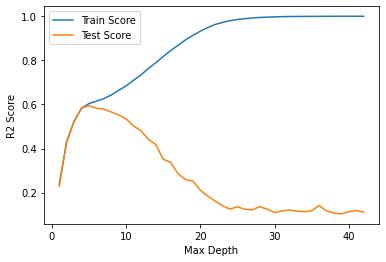

In [49]:
##Visualizing max depth to get the best R2
plt.plot(depths, scores['Train Score'], label='Train Score')
plt.plot(depths, scores['Test Score'], label='Test Score')
plt.ylabel('R2 Score')
plt.xlabel('Max Depth')
plt.legend()
plt.show()

In [50]:
## sorted by highest Test Scores
sorted_scores = scores.sort_values(by='Test Score', ascending=False)
## Display the first (5) rows of the dataframe
sorted_scores.head()

,Train Score,Test Score
5,0.60394,0.59471
4,0.582625,0.584005
6,0.615072,0.582408
7,0.626453,0.578864
8,0.642724,0.565564


In [51]:
best_depth = sorted_scores.index[0]
best_depth

5

In [52]:
dec_tree = DecisionTreeRegressor(max_depth=best_depth, random_state = 42)
## Model pipeline
dec_tree_pipe = make_pipeline(preprocessor, dec_tree)
## Fit the model
dec_tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Item_Weight',
                                                   'Item_Visibility',
                                                   'Item_MRP']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Item_Fat_Content',
                                                   'Item_Type',
                                                   'Outlet_Location_Type',
                                                   'Outlet_Type',
                                                   'Outlet_Size'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=5, random_state=42))])

In [53]:
model_metrics(dec_tree_pipe, x_train=X_train, y_train=y_train, 
                          x_test=X_test, y_test=y_test, 
                           model_name='Decision Tree Model')

Decision Tree Model Train Scores
MAE: 762.6102 
MSE: 1172122.7729 
RMSE: 1082.6462 
R2: 0.6039397

Decision Tree Model Test Scores
MAE: 738.3173 
MSE: 1118185.9731 
RMSE: 1057.4431 
R2: 0.59471



In [ ]:
## This model did better than the linear regression, with a higher R2 model for train and test data
## Although still high, the RMSE model was lower than it was in the linear regression model

## I recommend using the Decision Tree model because it had a moderate R2 score (0.60 for train and 0.59 for test), both of which were better than the Linear Regression model
## This model also had a low variance between the train and test data 